## Bonus: Temperature Analysis II

In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [10]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip (Aug 1st - Aug 7th) using the matching dates from the data
min_avg_max = calc_temps('2017-08-01', '2017-08-07')
min_avg_max

[(72.0, 79.25, 83.0)]

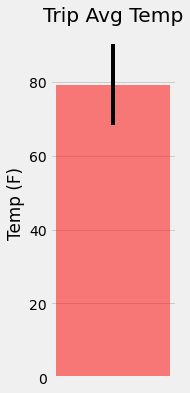

In [30]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
peak_to_peak = min_avg_max[0][2]-min_avg_max[0][0]

plt.subplots(figsize=(2,6))
plt.bar(1,min_avg_max[0][1],yerr=peak_to_peak, color = 'r', alpha =0.5) # bar height equals tavg a.k.a min_avg_max[0][1]
plt.xticks([0])
plt.ylabel("Temp (F)")
plt.title("Trip Avg Temp")
plt.savefig('Images/Trip_Avg_Temp.png')

plt.show()

### Daily Rainfall Average

In [12]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# # Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rain_station = pd.read_sql("SELECT s.station,s.name,s.latitude,s.longitude,s.elevation,sum(m.prcp) as 'Total Rainfall'\
                            FROM station s\
                            JOIN measurement m ON(s.station = m.station)\
                            WHERE m.date BETWEEN '2017-08-01' AND '2017-08-07'\
                            GROUP BY s.station\
                            ORDER BY SUM(m.prcp) DESC" , engine)
rain_station.head(10)

,station,name,latitude,longitude,elevation,Total Rainfall
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.36
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.22
2,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.06
3,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.04
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.00


### Daily Temperature Normals

In [13]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [18]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip

start_date = '2017-08-01'
end_date = '2017-08-07'

#Use the date to create a range of dates.
date_list = pd.date_range(start_date, end_date).tolist()
date_list

#Strip off the year, and save a list of strings in the format %m-%d.
dates=[]
for date in date_list:
    dates.append (dt.datetime.strftime(date, '%m-%d')) 
    
#Use the daily_normals function to calculate the normals for each date string, 
#and append the results to a list called normals.
normals=[]
for date in dates:
    normals.append(daily_normals(date))
print("My Vacation Date: Aug 01 through Aug 07")
for normal in normals:
    print(normal)



My Vacation Date: Aug 01 through Aug 07
[(67.0, 75.54, 83.0)]
[(68.0, 75.60377358490567, 84.0)]
[(70.0, 76.61111111111111, 85.0)]
[(69.0, 76.71153846153847, 84.0)]
[(69.0, 76.14814814814815, 82.0)]
[(67.0, 76.25, 83.0)]
[(71.0, 77.15686274509804, 83.0)]


In [23]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normal_temp=[]
for normal in normals:
    normal_temp.append(np.ravel(normal))
travel_df = pd.DataFrame(normal_temp, columns=['min(tobs)', 'avg(tobs)', 'max(tobs)'])
travel_df.index=[str(date.strftime('%Y-%m-%d')) for date in date_list]
travel_df

,min(tobs),avg(tobs),max(tobs)
2017-08-01,67.0,75.540000,83.0
2017-08-02,68.0,75.603774,84.0
2017-08-03,70.0,76.611111,85.0
2017-08-04,69.0,76.711538,84.0
2017-08-05,69.0,76.148148,82.0
2017-08-06,67.0,76.250000,83.0
2017-08-07,71.0,77.156863,83.0


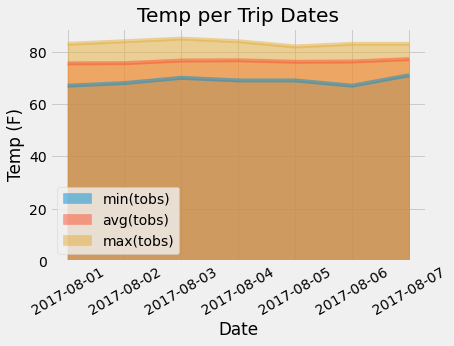

In [31]:
# Plot the daily normals as an area plot with `stacked=False`
ax = travel_df.plot.area(stacked=False, rot=30)
plt.yticks(size=14)
plt.ylabel("Temp (F)")
plt.xlabel ("Date")
plt.title("Temp per Trip Dates")
plt.savefig('Images/Temp_per_Trip_Dates.png')

plt.show()

## Close Session

In [27]:
session.close()